In [1]:
import eland as ed
import numpy as np
import matplotlib.pyplot as plt
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv
from app.utils.backtesting_utils import get_macd

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
%%capture
ticker="ASML"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_macd = ed.eland_to_pandas(df_eod).sort_values(by='date_reference', ascending=True).tail(100).set_index('date_reference')

short_period = 7
long_period = 20
signal_period = 6
df_macd, df_crossovers = get_macd(df_macd, short_period, long_period, signal_period)

In [4]:
df_macd.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,short_ema,long_ema,macd,signal,histogram,prev_macd,prev_signal,position,returns,strategy
date_reference,,,,,,,,,,,,,,,,
2025-10-20,ASML,1042.150,1052.170,1031.49,1031.750,1271713,1014.114440,978.422506,35.691934,34.726803,0.965130,33.054904,34.340751,1,0.012436,0.012436
2025-10-21,ASML,1025.020,1037.475,1024.15,1036.305,1072158,1016.840830,982.860363,33.980467,34.513564,-0.533097,35.691934,34.726803,-1,-0.016574,-0.016574
2025-10-22,ASML,1011.565,1033.180,997.67,1026.450,1328598,1015.521872,985.594138,29.927735,33.203327,-3.275593,33.980467,34.513564,1,-0.013213,0.013213
2025-10-23,ASML,1036.410,1040.500,1004.50,1004.520,1318221,1020.743904,990.433744,30.310161,32.376708,-2.066548,29.927735,33.203327,1,0.024264,0.024264
2025-10-24,ASML,1033.100,1043.400,1032.18,1037.930,1032742,1023.832928,994.497197,29.335731,31.507858,-2.172126,30.310161,32.376708,1,-0.003199,-0.003199


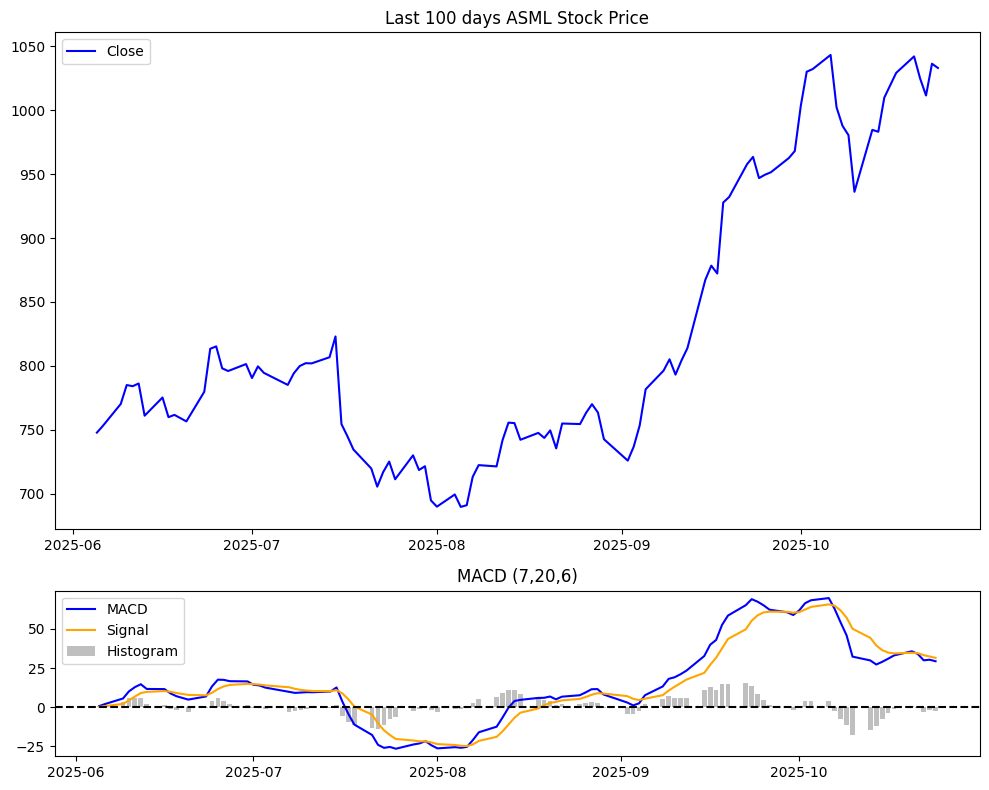

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top: Price plot
axs[0].plot(df_macd.index, df_macd['val_close'], label='Close', color='blue')
axs[0].set_title(f"Last 100 days {ticker} Stock Price")
axs[0].legend()

# Bottom: MACD plot
axs[1].plot(df_macd.index, df_macd['macd'], label='MACD', color='blue')
axs[1].plot(df_macd.index, df_macd['signal'], label='Signal', color='orange')
axs[1].bar(df_macd.index, df_macd['histogram'], label='Histogram', color='gray', alpha=0.5)
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_title(f"MACD ({short_period},{long_period},{signal_period})")
axs[1].legend()

plt.tight_layout()
plt.show()

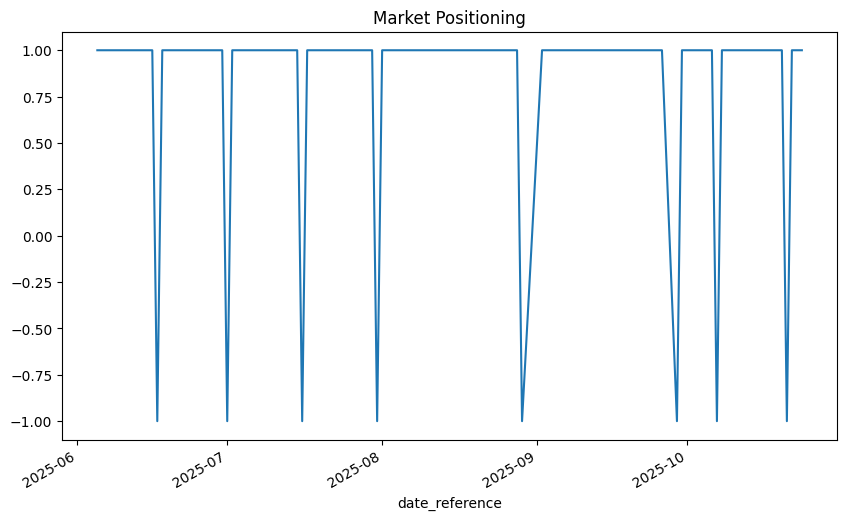

In [6]:
df_macd['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [7]:
df_macd[['returns', 'strategy']].sum().apply(np.exp)

returns     1.390856
strategy    1.539959
dtype: float64

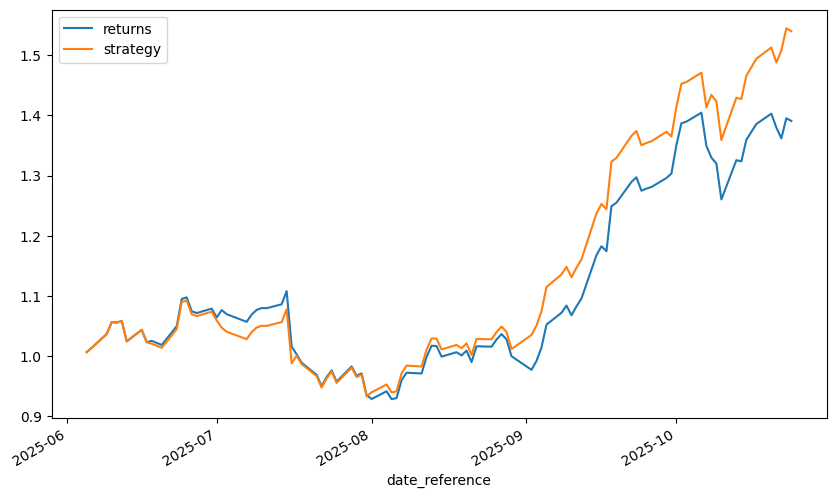

In [8]:
df_macd[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));

In [9]:
df_crossovers[['val_close', 'macd', 'signal', 'histogram', 'position']]

,val_close,macd,signal,histogram,position
date_reference,,,,,
2025-06-17,759.860,8.845593,9.894593,-1.049000,-1
2025-06-18,761.640,7.060016,9.084714,-2.024698,1
2025-07-01,790.470,14.320511,14.721760,-0.401249,-1
2025-07-02,799.590,13.919347,14.492499,-0.573152,1
2025-07-16,754.450,3.490309,8.810139,-5.319830,-1
2025-07-17,744.910,-4.277657,5.070768,-9.348426,1
2025-07-31,694.710,-24.239214,-22.423214,-1.816000,-1
2025-08-01,689.820,-26.210874,-23.505403,-2.705471,1
2025-08-29,742.620,8.160436,8.741692,-0.581256,-1
